# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [1]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


#### **1.2** Import necessary libraries

In [2]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [4]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [5]:
# define a function to load json file to a dataframe
def load_json_dataframe(file_path):
  """Reads a JSON file and returns a pandas DataFrame.

  Args:
    file_path: The path to the JSON file.

  Returns:
    A pandas DataFrame representing the JSON data, or None if an invalid json was passed.
  """
  try:
      with open(file_path, 'r') as file:
          data = json.load(file)
          df = pd.DataFrame(data)
          return df
  except FileNotFoundError:
      print(f"Error: File not found at {file_path}")
      return None
  except json.JSONDecodeError:
      print(f"Error: Invalid JSON format in {file_path}")
      return None
  except Exception as e:
      print(f"An unexpected error occurred: {e}")
      return None

##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [6]:
# read the json file by giving the file path and create a dataframe
recipe_df = load_json_dataframe('ingredient_and_quantity.json')

##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [7]:
# display first five rows of the dataframe - df
recipe_df.head(5)

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2                                                                  1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice                                                                                       quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3  500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and  quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4                                                                                                                                                           1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry                                                                                                                                                                                                                                                                 qua

In [8]:
# print the dimensions of dataframe - df
recipe_df.shape

(285, 2)

In [9]:
# print the information of the dataframe
recipe_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [10]:
# split the input and pos into input_tokens and pos_tokens in the dataframe

# Tokenize input
recipe_df['input_tokens'] = recipe_df['input'].apply(lambda x: x.strip().split())
# Tokenize POS
recipe_df['pos_tokens'] = recipe_df['pos'].apply(lambda x: x.strip().split())

In [11]:
# display first five rows of the dataframe - df
recipe_df.head(5)

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                   input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]                                                                                                                                                        [quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient                                                                                                [2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]                               

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [12]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
recipe_df['input_length'] = recipe_df['input_tokens'].str.len()
recipe_df['pos_length'] = recipe_df['pos_tokens'].str.len()

In [13]:
# check for the equality of input_length and pos_length in the dataframe
print(recipe_df['input_length'].equals(recipe_df['pos_length']))

False


In [14]:
def validate_data(df):
    """
    Validates the dataframe by checking if the lengths of input_tokens and pos_tokens are equal for each row.
    Prints error messages for mismatched rows and returns the number of invalid rows.

    Args:
        df : The DataFrame to validate. Dataframe should have 'input_length' and 'pos_length' columns

    Returns:
        int: The number of invalid rows.
    """
    invalid_rows = 0
    for index, row in df.iterrows():
        if (row['input_length'] != row['pos_length']) or row['input_length'] == 0 or row['pos_length'] == 0:
            print(f"Error: Mismatched or Zero lengths in row {index}: input_length={row['input_length']}, pos_length={row['pos_length']}")
            invalid_rows += 1
    return invalid_rows

In [15]:
num_invalid_rows = validate_data(recipe_df)
print(f"Total invalid rows: {num_invalid_rows}")

Error: Mismatched or Zero lengths in row 17: input_length=15, pos_length=14
Error: Mismatched or Zero lengths in row 27: input_length=37, pos_length=36
Error: Mismatched or Zero lengths in row 79: input_length=38, pos_length=37
Error: Mismatched or Zero lengths in row 164: input_length=54, pos_length=53
Error: Mismatched or Zero lengths in row 207: input_length=18, pos_length=17
Total invalid rows: 5


##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [16]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it
def unique_labels(df):
  """
  Checks for all the unique pos labels in the recipe dataframe & print it.

  Args:
      df: pandas DataFrame containing 'pos_tokens' column.
  """
  unique_pos_labels = set([label for sublist in df['pos_tokens'] for label in sublist])
      
  print("Unique POS labels:", unique_pos_labels)

unique_labels(recipe_df)

Unique POS labels: {'quantity', 'ingredient', 'unit'}


##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

In [17]:
print(recipe_df.describe())

# Check for missing values
print("\nMissing values:\n", recipe_df.isna().sum() * 100 / len(recipe_df))

# Analyze input and pos token lengths
print("\nInput token length distribution:\n", recipe_df['input_length'].describe())
print("\nPos token length distribution:\n", recipe_df['pos_length'].describe())

# Explore unique input and pos tokens
print("\nNumber of unique input tokens:", len(set([token for sublist in recipe_df['input_tokens'] for token in sublist])))
print("Number of unique pos tokens:", len(set([token for sublist in recipe_df['pos_tokens'] for token in sublist])))

       input_length  pos_length
count    285.000000  285.000000
mean      35.621053   35.603509
std       13.892580   13.897284
min        7.000000    7.000000
25%       26.000000   26.000000
50%       34.000000   34.000000
75%       43.000000   43.000000
max       93.000000   93.000000

Missing values:
 input           0.0
pos             0.0
input_tokens    0.0
pos_tokens      0.0
input_length    0.0
pos_length      0.0
dtype: float64

Input token length distribution:
 count    285.000000
mean      35.621053
std       13.892580
min        7.000000
25%       26.000000
50%       34.000000
75%       43.000000
max       93.000000
Name: input_length, dtype: float64

Pos token length distribution:
 count    285.000000
mean      35.603509
std       13.897284
min        7.000000
25%       26.000000
50%       34.000000
75%       43.000000
max       93.000000
Name: pos_length, dtype: float64

Number of unique input tokens: 1067
Number of unique pos tokens: 3


<font color = red>[write your answer]</font> <br>
- There are 5 rows where number of input token length and pos length is not matching. We will treat these rows as invalid
- Indexes with mismatched rows are: 17,27,79,164 and 207
- There are no rows with missing values
- Number of unique input tokens: 1067
- Number of unique pos tokens: 3
  

##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [18]:
# drop the irrelevant recipe data
recipe_df = recipe_df[~(recipe_df['input_length'] != recipe_df['pos_length'])]
recipe_df.shape

(280, 6)

##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [19]:
# update the input and pos length in input_length and pos_length
recipe_df['input_length'] = recipe_df['input_tokens'].str.len()
recipe_df['pos_length'] = recipe_df['pos_tokens'].str.len()

##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [20]:
# validate the input length and pos length as input_length and pos_length
num_invalid_rows = validate_data(recipe_df)
print(f"Total invalid rows: {num_invalid_rows}")

Total invalid rows: 0


## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [21]:
# split the dataset into training and validation sets
train_df, val_df = train_test_split(recipe_df, test_size=0.3, random_state=42)

###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [22]:
# print the first five rows of train_df
train_df.head(5)

input                                                                                                                                                                                                                                                                                                                                                                                                                                       pos                                                                                                                                                                                                                                                                                           input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                          pos_tokens  input_length  pos_length
179                                                        250 grams Okra Oil 1 Onion finely chopped Tomato Grated teaspoon Ginger 2 Garlic Finely 1/2 Cumin seeds 1/4 Teaspoon asafoetida cup cottage cheese pinched coriander powder mango red chilli turmeric                                                                                                                        quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient unit ingredient quantity ingredient ingredient quantity ingredient ingredient quantity unit ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                  [250, grams, Okra, Oil, 1, Onion, finely, chopped, Tomato, Grated, teaspoon, Ginger, 2, Garlic, Finely, 1/2, Cumin, seeds, 1/4, Teaspoon, asafoetida, cup, cottage, cheese, pinched, coriander, powder, mango, red, chilli, turmeric]                                                                                                                                  [quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]            31          31
57   200 grams Paneer Homemade Cottage Cheese 2 Potato Aloo Bay leaf tej patta Dry Red Chilli 1 tablespoon Panch Phoran Masala roasted and powdered Tomato big sized teaspoon Turmeric powder Haldi Cumin seeds Jeera Ginger grated Salt 1/2 Sugar Sunflower Oil  quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient  [200, grams, Paneer, Homemade, Cottage, Cheese, 2, Potato, Aloo, Bay, leaf, tej, patta, Dry, Red, Chilli, 1, tablespoon, Panch, Phoran, Masala, roasted, and, powdered, Tomato, big, sized, teaspoon, Turmeric, powder, Haldi, Cumin, seeds, Jeera, Ginger, grated, Salt, 1/2, Sugar, Sunflower, Oil]  [quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ing

In [23]:
# print the first five rows of the val_df
val_df.head(5)

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                                                                                                        input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        pos_tokens  input_length  pos_length
35                                                                                                                                                                                                                                                                                       1 cup Ada 2 liter Milk 3/4 Sugar tablespoon Ghee 1/2 teaspoon Cardamom Powder Elaichi                                                                                                                                                                                                                                                                                                                                                                                                                                                     quantity unit ingredient quantity unit ingredient quantity ingredient unit ingredient quantity unit ingredient ingredient ingredient                                                                                                                                                                                                                                                                                                                               [1, cup, Ada, 2, liter, Milk, 3/4, Sugar, tablespoon, Ghee, 1/2, teaspoon, Cardamom, Powder, Elaichi]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              [quantity, unit, ingredient, quantity, unit, ingredient, quantity, ingredient, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient]            15          15
111  1 Carrot Gajjar chopped 7 Potatoes Aloo 2 cups Cauliflower gobi cut to small florets Onion tablespoon Ginger Garlic Paste Salt teaspoons Sunflower Oil 1/2 cup Fresh coconut grated teaspoon Whole Black Peppercorns Green Chillies Fennel seeds Saunf Poppy 6 Cashew nuts inch Cinnamon Stick Dalchini Star anise 3 Cloves Laung Cardamom Elaichi P

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [24]:
# extract the training and validation sets by taking input_tokens and pos_tokens
X_train = train_df['input_tokens']
X_val = val_df['input_tokens']
y_train = train_df['pos_tokens']
y_val = val_df['pos_tokens']

In [25]:
# validate the shape of training and validation samples
assert len(X_train) == len(y_train), "Training input and output lengths do not match."
assert len(X_val) == len(y_val), "Validation input and output lengths do not match."
print("Training and Validation shapes validated successfully!")

Training and Validation shapes validated successfully!


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [26]:
# Display the number of unique labels present in y_train
unique_labels_y_train = set([token for sublist in y_train for token in sublist])
print("Unique labels in y_train: ", unique_labels_y_train)

Unique labels in y_train:  {'quantity', 'ingredient', 'unit'}


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [27]:
# flatten the list for nested_list (input_tokens, pos_tokens)
def flatten_list(nested_list):
  flat_list = [item for sublist in nested_list for item in sublist]
  return flat_list

flat_input_tokens = flatten_list(X_train)
flat_pos_tokens = flatten_list(y_train)

print(f"Length of flat_input_tokens: {len(flat_input_tokens)}")
print(f"Length of flat_pos_tokens: {len(flat_pos_tokens)}")

Length of flat_input_tokens: 7114
Length of flat_pos_tokens: 7114


In [28]:
# initialise the dataset_name
dataset_name = 'Training'

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [29]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens
def extract_and_validate_tokens(df, dataset_name):
    """
    Extracts and validates input and PoS tokens from a DataFrame.

    Args:
        df: The input DataFrame.
        dataset_name: The name of the dataset (e.g., 'train', 'validation').
    """

    input_tokens = df['input_tokens'].tolist()
    pos_tokens = df['pos_tokens'].tolist()

    flat_input_tokens = flatten_list(input_tokens)
    flat_pos_tokens = flatten_list(pos_tokens)

    print(f"Number of input tokens in {dataset_name} set:", len(flat_input_tokens))
    print(f"Number of pos tokens in {dataset_name} set:", len(flat_pos_tokens))

    if len(flat_input_tokens) != len(flat_pos_tokens):
        print("Error: Mismatch in the number of input and PoS tokens.")
        return None
    else:
        print(f"Input and PoS token counts match for {dataset_name} set.")
        # Display the first 10 records with input and pos tokens
        print(f"\nFirst 10 records of {dataset_name} set:")
        for i in range(min(10, len(df))):
            print(f"Record {i+1}:")
            print(f"  Input Tokens: {df['input_tokens'].iloc[i]}")
            print(f"  PoS Tokens: {df['pos_tokens'].iloc[i]}")
        return flat_input_tokens, flat_pos_tokens   

In [30]:
# extract the tokens and its pos tags
flat_input_tokens, flat_pos_tokens = extract_and_validate_tokens(train_df, dataset_name)

Number of input tokens in Training set: 7114
Number of pos tokens in Training set: 7114
Input and PoS token counts match for Training set.

First 10 records of Training set:
Record 1:
  Input Tokens: ['250', 'grams', 'Okra', 'Oil', '1', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated', 'teaspoon', 'Ginger', '2', 'Garlic', 'Finely', '1/2', 'Cumin', 'seeds', '1/4', 'Teaspoon', 'asafoetida', 'cup', 'cottage', 'cheese', 'pinched', 'coriander', 'powder', 'mango', 'red', 'chilli', 'turmeric']
  PoS Tokens: ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'unit', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']
Record 2:
  Input Tokens: ['200', 'grams', 'Paneer', 'Homemade', 'Cottage', 'Cheese', '2', 'P

#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [31]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays

def categorize_tokens(input_tokens, pos_tags):
    ingredients = []
    units = []
    quantities = []

    if not set(pos_tags).issubset({'ingredient', 'unit', 'quantity'}):
        return ingredients, units, quantities
    
    for token, pos_tag in zip(input_tokens, pos_tags):
        if pos_tag == 'ingredient':
            ingredients.append(token)
        elif pos_tag == 'unit':
            units.append(token)
        elif pos_tag == 'quantity':
            quantities.append(token)

    return ingredients, units, quantities

In [32]:
#  call the function to categorise the labels into respective list
ingredients,units,quantities=categorize_tokens(flat_input_tokens, flat_pos_tokens)

#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [33]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items
def get_top_frequent_items(item_list, pos_label, dataset_name, top_n=10):
    """
    Gets the top frequent items based on the provided parameters.

    Args:
        item_list: A list of lists, where each inner list represents a sequence of tokens.
        pos_label: The POS tag to filter items by ('ingredient', 'unit', or 'quantity').
        dataset_name: The name of the dataset ('Training' or 'Validation').
        top_n: The number of top frequent items to return (default is 10).

    Returns:
        A list of tuples, where each tuple contains a frequent item and its count.
        Returns an empty list if the pos_label is invalid or no items match the criteria.
    """
        
    item_counts = Counter(item_list)
    top_items = item_counts.most_common(top_n)

    print(f"Top 10 most frequent {pos_label} in {dataset_name} set:")
    for item, count in top_items:
        print(f"{item}: {count}")

    return top_items

In [34]:
# get the top ingredients which are frequently seen in the recipe
top_ingredients_train = get_top_frequent_items(ingredients, 'ingredient', dataset_name)

Top 10 most frequent ingredient in Training set:
powder: 129
Salt: 102
seeds: 89
Green: 85
chopped: 84
Oil: 83
Red: 81
Chilli: 77
Coriander: 71
Sunflower: 65


In [35]:
# get the top units which are frequently seen in the recipe
top_units_train = get_top_frequent_items(units, 'unit', dataset_name)

Top 10 most frequent unit in Training set:
teaspoon: 162
cup: 136
tablespoon: 99
grams: 63
tablespoons: 61
inch: 52
cups: 50
sprig: 41
cloves: 39
teaspoons: 39


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [36]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name
def plot_top_items(top_items, label, dataset_name):
    """Plots the top items with their frequencies.

    Args:
        top_items: A list of tuples, where each tuple contains an item name and its count in dataset.
        label: A string indicating whether the items are ingredients or units.
        dataset_name: A string indicating the dataset name (e.g., 'training', 'validation').
    """

    if not top_items:
        print(f"No top {label} found for {dataset_name} dataset.")
        return

    item_names, counts = zip(*top_items)
    #item_names = [item[0] for item in top_items]
    #frequencies = [item[1] for item in top_items]
    
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    plt.bar(item_names, counts)
    plt.xlabel(label)
    plt.ylabel("Counts")
    plt.title(f"Top {label} in {dataset_name} Dataset")
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()

#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



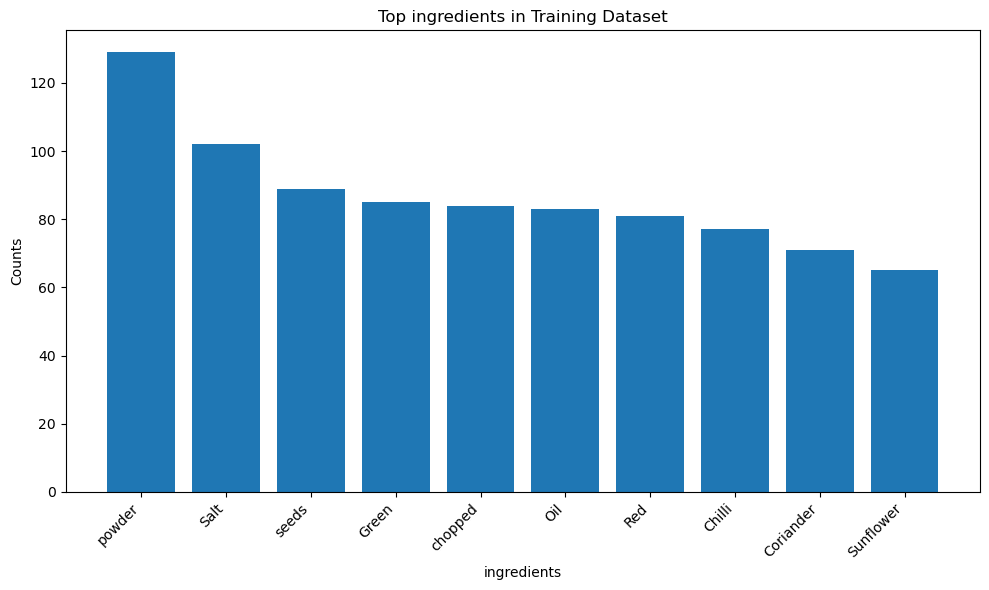

In [37]:
# plot the top frequent ingredients in training data
plot_top_items(top_ingredients_train, 'ingredients', dataset_name)

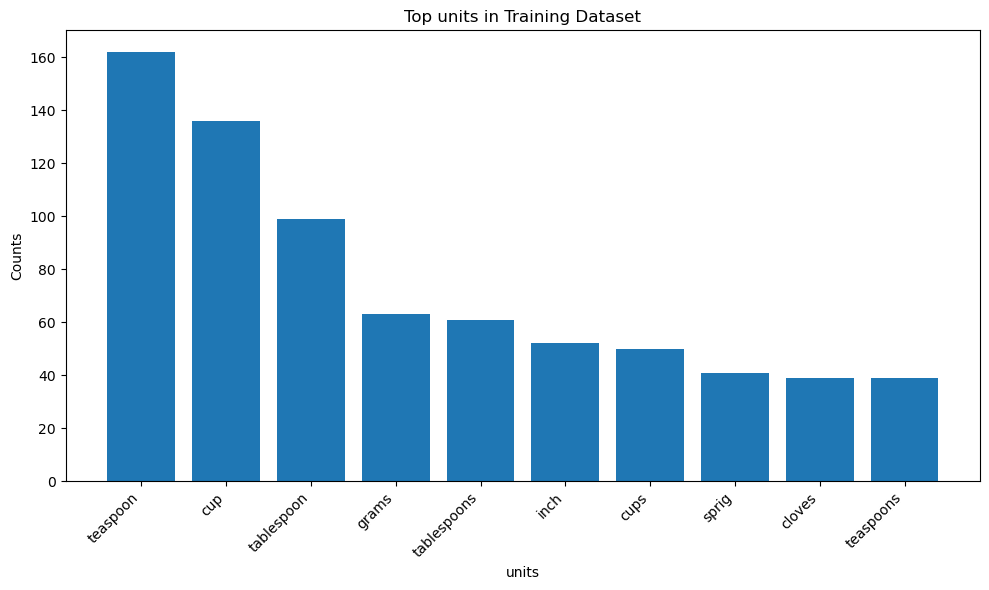

In [38]:
# plot the top frequent units in training data
plot_top_items(top_units_train, 'units', dataset_name)

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [39]:
# initialise the dataset_name
dataset_name = 'Validation'

In [40]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe
flat_input_tokens_val, flat_pos_tokens_val = extract_and_validate_tokens(val_df, dataset_name)
ingredients_val, units_val, quantities_val = categorize_tokens(flat_input_tokens_val, flat_pos_tokens_val)
top_ingredients_val = get_top_frequent_items(ingredients_val, 'ingredient', dataset_name)
top_units_val = get_top_frequent_items(units_val, 'unit', dataset_name)

Number of input tokens in Validation set: 2876
Number of pos tokens in Validation set: 2876
Input and PoS token counts match for Validation set.

First 10 records of Validation set:
Record 1:
  Input Tokens: ['1', 'cup', 'Ada', '2', 'liter', 'Milk', '3/4', 'Sugar', 'tablespoon', 'Ghee', '1/2', 'teaspoon', 'Cardamom', 'Powder', 'Elaichi']
  PoS Tokens: ['quantity', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity', 'ingredient', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient']
Record 2:
  Input Tokens: ['1', 'Carrot', 'Gajjar', 'chopped', '7', 'Potatoes', 'Aloo', '2', 'cups', 'Cauliflower', 'gobi', 'cut', 'to', 'small', 'florets', 'Onion', 'tablespoon', 'Ginger', 'Garlic', 'Paste', 'Salt', 'teaspoons', 'Sunflower', 'Oil', '1/2', 'cup', 'Fresh', 'coconut', 'grated', 'teaspoon', 'Whole', 'Black', 'Peppercorns', 'Green', 'Chillies', 'Fennel', 'seeds', 'Saunf', 'Poppy', '6', 'Cashew', 'nuts', 'inch', 'Cinnamon', 'Stick', 'Dalchini', 'Star'

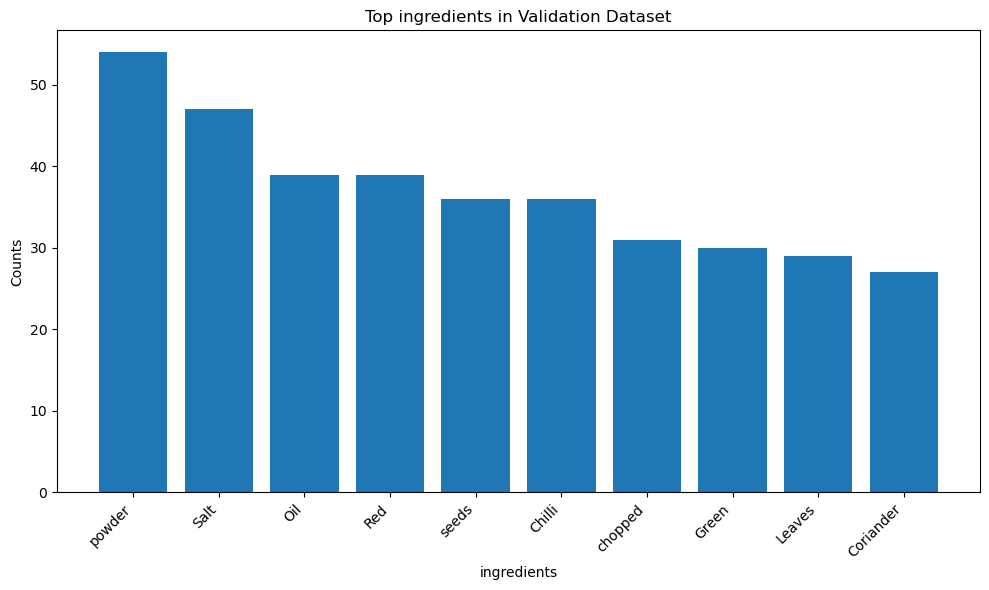

In [41]:
# plot the top frequent ingredients in validation data
plot_top_items(top_ingredients_val, 'ingredients', dataset_name)

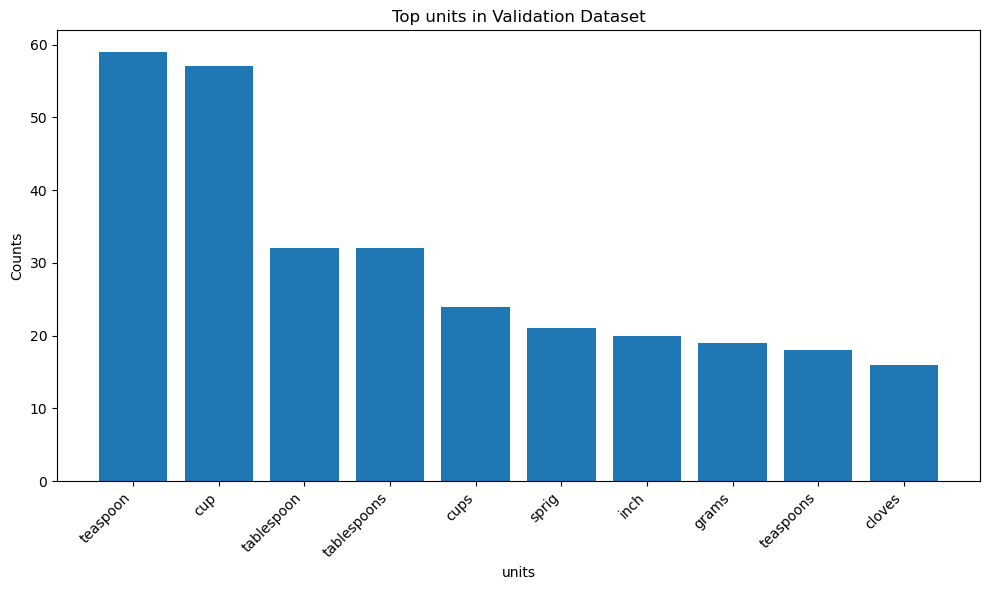

In [42]:
# plot the top frequent units in validation data
plot_top_items(top_units_val, 'units', dataset_name)

## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [43]:
# define unit and quantity keywords along with quantity pattern
unit_keywords = set(units)
quantity_keywords = {'few','little','large','half','quarter','one','two','three','four','five','six','seven','eight','nine','ten','taste','per','dozen'}
quantity_pattern = r"\d+(?:[-./\s]\d+(?:/\d+)?)?"

In [44]:
# load spaCy model
nlp = spacy.load('en_core_web_sm')

In [45]:
#added custom quantity pattern to spacy tokenizer
nlp.tokenizer.token_match = re.compile(quantity_pattern).match

##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [46]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions

def word2features(sent, i):
    """
    Generates features for a given token in a sentence, incorporating contextual information.

    Args:
        sent: A list of tokens representing the sentence.
        i: The index of the current token in the sentence.

    Returns:
        A dictionary of features for the token.
    """
    # Process the entire sentence with spaCy
    doc = nlp(" ".join(sent))
    token = doc[i]

    # --- Core Features ---
    features = {
        'bias': 1.0,
        'token': token.text.lower(),
        'lemma': token.lemma_.lower(),
        'pos_tag': token.pos_,
        'tag': token.tag_,
        'dep': token.dep_,
        'shape': token.shape_,
        'is_stop': token.is_stop, 
        'is_digit': token.is_digit,
        'has_digit': token.is_digit or any(c.isdigit() for c in token.text),
        'has_alpha': token.is_alpha,
        'hyphenated': '-' in token.text,
        'slash_present': '/' in token.text,
        'is_title': token.is_title,
        'is_upper': token.is_upper,
        'is_punct': token.is_punct
    } 
    # --- Improved Quantity & Unit Detection ---
    features['is_unit'] = token.text.lower() in unit_keywords
    features['is_quantity_keyword'] = token.text.lower() in quantity_keywords
    features['is_quantity'] = bool(re.match(quantity_pattern, token.text))
    features['is_numeric'] = token.is_digit
    features['is_fraction'] = '/' in token.text and all(part.isdigit() for part in token.text.split('/'))
    features['is_decimal'] = '.' in token.text and all(part.isdigit() for part in token.text.split('.'))

    # --- Contextual Features ---
    features['prev_token'] = doc[i - 1].text.lower() if i > 0 else 'BOS'
    features['prev_is_quantity'] = bool(re.match(quantity_pattern, doc[i - 1].text)) if i > 0 else False
    features['prev_is_digit'] = doc[i - 1].is_digit if i > 0 else False
    features['BOS'] = (i == 0)
    features['next_token'] = doc[i + 1].text.lower() if i < len(doc) - 1 else 'EOS'
    features['next_is_unit'] = doc[i + 1].text.lower() in unit_keywords if i < len(doc) - 1 else False
    features['next_is_ingredient'] = not (doc[i + 1].text.lower() in unit_keywords or bool(re.match(quantity_pattern, doc[i + 1].text))) if i < len(doc) - 1 else False
    features['EOS'] = (i == len(doc) - 1)

    return features


### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [47]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [48]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features
X_train_features = [sent2features(s) for s in X_train]

In [49]:
X_val_features = [sent2features(s) for s in X_val]

##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [50]:
# Convert labels into list as y_train_labels and y_val_labels
y_train_labels = [labels for labels in y_train]

y_val_labels = [labels for labels in y_val]

##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [51]:
# print the length of train features and labels
print(f"Length of X_train_features : {len(X_train_features)}")
print(f"Length of y_train_labels : {len(y_train_labels)}")

Length of X_train_features : 196
Length of y_train_labels : 196


In [52]:
# print the length of validation features and labels
print(f"Length of X_val_features : {len(X_val_features)}")
print(f"Length of y_val_labels : {len(y_val_labels)}")

Length of X_val_features : 84
Length of y_val_labels : 84


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [53]:
# Flatten labels in y_train
y_train_flat = flatten_list(y_train)

##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [54]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts
label_counts = Counter(y_train_flat)
total_samples = sum(label_counts.values())

print(f"Label Counts: {label_counts}")
print(f"Total Samples: {total_samples}")

Label Counts: Counter({'ingredient': 5323, 'quantity': 980, 'unit': 811})
Total Samples: 7114


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [55]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts
weight_dict = {}
for label, count in label_counts.items():
  weight_dict[label] = total_samples / count

In [56]:
# penalise ingredient label
if 'ingredient' in weight_dict:
  weight_dict['ingredient'] *= 1.5
  print(f"Adjusted weight for ingredient: {weight_dict['ingredient']}")

Adjusted weight for ingredient: 2.0046965996618447


##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [57]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)
def extract_features_with_class_weights(X, y, weight_dict):
    """
    Extracts features and applies class weights.

    Args:
        X: Input tokens.
        y: Labels.
        weight_dict: Class weights.

    Returns:
        A list of feature dictionaries with updated weights.
    """
    X_features = []
    for i, sentence in enumerate(X):
      sentence_features = sent2features(sentence)
      for j, features in enumerate(sentence_features):
          label = y[i][j]  # Get the corresponding label
          if label in weight_dict:
              features['bias'] = weight_dict[label]
          else:
            features['bias'] = 1.0
      X_features.append(sentence_features)
    return X_features

##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [58]:
# Apply manually computed class weights
X_train_weighted_features = extract_features_with_class_weights(X_train, y_train_labels, weight_dict)

In [59]:
X_val_weighted_features = extract_features_with_class_weights(X_val, y_val_labels, weight_dict)

## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [60]:
# initialise CRF model with the specified hyperparameters and use weight_dict
crf = sklearn_crfsuite.CRF(max_iterations=100, algorithm='lbfgs', c1=0.5, c2=1.0, all_possible_transitions=True)
# train the CRF model with the weighted training data
crf.class_weight = weight_dict  #Applying weight_dict
crf.fit(X_train_weighted_features, y_train_labels)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.5, c2=1.0,
    max_iterations=100)

### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [61]:
# evaluate on the training dataset
y_pred_train = crf.predict(X_train_weighted_features)

In [62]:
# specify the flat classification report by using training data for evaluation
print(metrics.flat_classification_report(y_train_labels, y_pred_train))

              precision    recall  f1-score   support

  ingredient       1.00      1.00      1.00      5323
    quantity       0.99      0.99      0.99       980
        unit       0.99      0.99      0.99       811

    accuracy                           1.00      7114
   macro avg       0.99      0.99      0.99      7114
weighted avg       1.00      1.00      1.00      7114



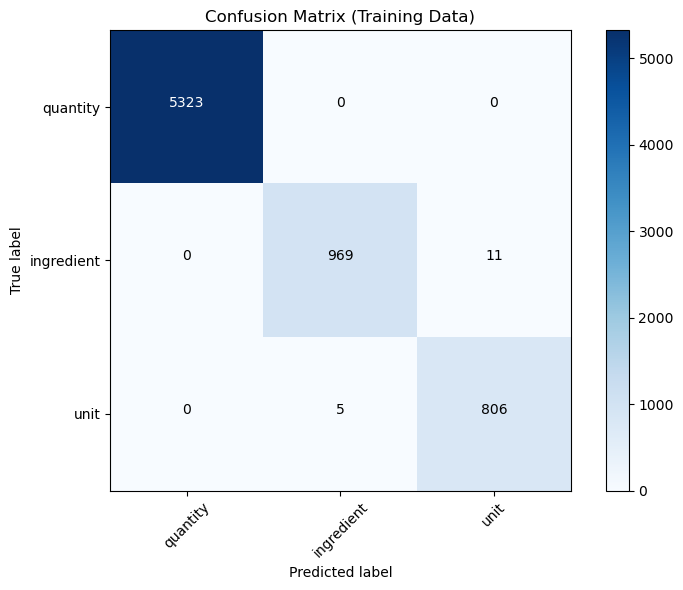

In [63]:
# create a confusion matrix on training datset
cm = confusion_matrix(flatten_list(y_train_labels), flatten_list(y_pred_train))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Training Data)')
plt.colorbar()

classes = list(set(flatten_list(y_train_labels))) #Get unique labels
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [64]:
# dump the model using joblib as crf_model.pkl
joblib.dump(crf, 'crf_model.pkl') 

['crf_model.pkl']

## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [65]:
# predict the crf model on validation dataset
# Load the saved model
loaded_crf = joblib.load('crf_model.pkl')
# Predict on the validation data
y_val_pred = loaded_crf.predict(X_val_weighted_features)

In [66]:
# specify flat classification report
print(metrics.flat_classification_report(y_val_labels, y_val_pred))

              precision    recall  f1-score   support

  ingredient       1.00      1.00      1.00      2107
    quantity       0.98      0.99      0.98       411
        unit       0.98      0.97      0.98       358

    accuracy                           0.99      2876
   macro avg       0.99      0.99      0.99      2876
weighted avg       0.99      0.99      0.99      2876



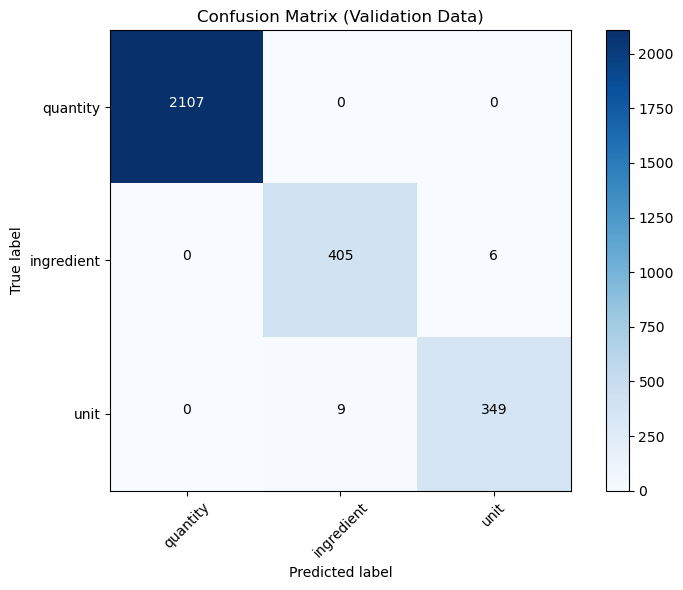

In [67]:
# create a confusion matrix on validation dataset
cm_val = confusion_matrix(flatten_list(y_val_labels), flatten_list(y_val_pred))

plt.figure(figsize=(8, 6))
plt.imshow(cm_val, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Validation Data)')
plt.colorbar()

classes = list(set(flatten_list(y_val_labels)))
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm_val.max() / 2.
for i, j in np.ndindex(cm_val.shape):
    plt.text(j, i, format(cm_val[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm_val[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [68]:
# flatten Labels and Initialise Error Data
y_true_flat = flatten_list(y_val_labels)
y_pred_flat = flatten_list(y_val_pred)
error_data = []

##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [69]:
# iterate and collect Error Information
X_val_list = X_val.to_list()
for i in range(len(X_val)): 
    for j in range(len(X_val_list[i])):
        if y_val_labels[i][j] != y_val_pred[i][j]:
            error_details = {}
            error_details['true_label'] = y_val_labels[i][j]
            error_details['predicted_label'] = y_val_pred[i][j]
            error_details['token'] = X_val_list[i][j]
            # get previous and next tokens with handling for boundary cases
            # Previous token (handle boundary case)
            prev_token = X_val_list[i][j - 1] if j > 0 else "BOS"
            error_details['prev_token'] = prev_token

            # Next token (handle boundary case)
            next_token = X_val_list[i][j + 1] if j < len(X_val_list[i]) - 1 else "EOS"
            error_details['next_token'] = next_token

            # Class weights (accessing from weight_dict)
            true_label_weight = weight_dict.get(y_val_labels[i][j], 1.0)  # Default to 1.0 if not found
            error_details['true_label_weight'] = true_label_weight
            predicted_label_weight = weight_dict.get(y_val_pred[i][j],1.0)
            error_details['predicted_label_weight'] = predicted_label_weight
            
            error_data.append(error_details)
            


##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [70]:
# Create DataFrame and Print Overall Accuracy
error_df = pd.DataFrame(error_data)
print(error_df.head())

# Calculate overall accuracy
correct_predictions = len(y_true_flat) - len(error_data)
overall_accuracy = (correct_predictions / len(y_true_flat)) * 100
print(f"Overall Accuracy: {overall_accuracy:.2f}%")

  true_label predicted_label      token prev_token  next_token  true_label_weight  predicted_label_weight
0       unit        quantity      sprig    (Split)       Curry           8.771887                7.259184
1   quantity            unit        for        Oil    kneading           7.259184                8.771887
2       unit        quantity  julienned     Ginger  tablespoon           8.771887                7.259184
3       unit        quantity      diced     Gajjar       small           8.771887                7.259184
4       unit        quantity       cold        Oil     pressed           8.771887                7.259184
Overall Accuracy: 99.48%


##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [71]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context

errors_by_label = error_df.groupby('true_label')

for label, label_errors in errors_by_label:
    print(f"\nAnalysis for Label: {label}")
        
    # Calculate accuracy for this label
    label_true_count = y_true_flat.count(label)
    label_error_count = len(label_errors)
    label_accuracy = ((label_true_count-label_error_count) / label_true_count) * 100 if label_true_count else 0

    print(f"  Accuracy: {label_accuracy:.2f}%")
    print(f"  Class Weight: {weight_dict.get(label, 'Not found')}")  # Access weight from the dictionary
        
    # Display the error DataFrame for this label
    print("\nError DataFrame:")

    # Select relevant columns for display
    columns_to_display = ['token', 'prev_token', 'next_token', 'true_label', 'predicted_label', 'true_label_weight', 'predicted_label_weight']
    print(label_errors[columns_to_display])


Analysis for Label: quantity
  Accuracy: 98.54%
  Class Weight: 7.259183673469388

Error DataFrame:
     token prev_token  next_token true_label predicted_label  true_label_weight  predicted_label_weight
1      for        Oil    kneading   quantity            unit           7.259184                8.771887
7        4      Sugar        Eggs   quantity            unit           7.259184                8.771887
8        2       Salt     Instant   quantity            unit           7.259184                8.771887
11       1     (hing)         Red   quantity            unit           7.259184                8.771887
12   pinch        Dal  Asafoetida   quantity            unit           7.259184                8.771887
14  cloves   Tomatoes      Garlic   quantity            unit           7.259184                8.771887

Analysis for Label: unit
  Accuracy: 97.49%
  Class Weight: 8.771886559802713

Error DataFrame:
         token    prev_token  next_token true_label predicted_label  true_

### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




 <font color = red>[Write your answer]</font>
### The validation dataset analysis reveals the following insights:

Overall Accuracy: The overall accuracy of the model on the validation set is 99.48%, indicating that model is having great performance in correctly classifying the labels.

Accuracy by labels: Analyzing the accuracy for each label reveals that the model accuracy is varying across labels. But, the accuracy for each label is also good. 

Error analysis insights: Examining misclassified tokens along with their surrounding context (previous and next tokens) does not reveal any pattern in the errors. Including 2 or 3 previous and next tokens might help to understand the pattern in the errors

## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Write your findings and conclusion.